Материал по энкодингу: https://dfedorov.spb.ru/pandas/Руководство%20по%20кодированию%20категориальных%20значений%20в%20Python.html?ysclid=lacgv2w7bq61763080

## Загрузим нужные библиотеки

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

%matplotlib inline

In [3]:
df = pd.read_csv("train.csv", index_col = 'id')

## Рассмотрим датасет поближе

In [4]:
df.head(5)

,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
id,,,,,,,,,,,
1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001
2,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011
3,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022
4,015DA44B523C062B5BFEFF3FB0E64B9E,30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022
5,95B19C6F3A504727AC3EA56EB7E3E80F,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1091021 entries, 1 to 1091021
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   ticket_id       1091021 non-null  object 
 1   ticket_type_nm  1091021 non-null  object 
 2   entrance_id     1091021 non-null  int64  
 3   entrance_nm     1091021 non-null  object 
 4   station_id      1091021 non-null  int64  
 5   station_nm      1091021 non-null  object 
 6   line_id         1091021 non-null  int64  
 7   line_nm         1091021 non-null  object 
 8   pass_dttm       1091021 non-null  object 
 9   time_to_under   1091021 non-null  float64
 10  label           1091021 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 99.9+ MB


In [6]:
sum(df['ticket_id'].value_counts()>1)

265232

Удалим все id билетов, так как они всегда разные и не могут влиять на предсказание

In [7]:
df.drop('ticket_id', axis =1, inplace = True)

Удалим entrance name, так как она дублирует id станции вхождения. ID входа и ID станции пока оставим и проверим в дальнейшем на корреляцию.

In [8]:
df.drop('entrance_nm', axis =1, inplace = True)

In [9]:
df.drop('station_nm', axis =1, inplace = True)

По той же причине удалим и название линии

In [10]:
df.drop('line_nm', axis =1, inplace = True)

In [11]:
df.head()

,ticket_type_nm,entrance_id,station_id,line_id,pass_dttm,time_to_under,label
id,,,,,,,
1,Пропуск FacePay,2402,11007,11,2022-09-12 05:00:13,216.316667,8001
2,СК учащегося 30 дней,110,2006,2,2022-09-12 05:00:54,648.183333,9011
3,БСК дружинника г.Москвы,110,2006,2,2022-09-12 05:00:55,865.333333,7022
4,30 дней,110,2006,2,2022-09-12 05:01:13,1048.233333,2022
5,КОШЕЛЕК,110,2006,2,2022-09-12 05:02:55,965.600000,2017


Посмотрим на распределение двух основных величин 

<AxesSubplot:>

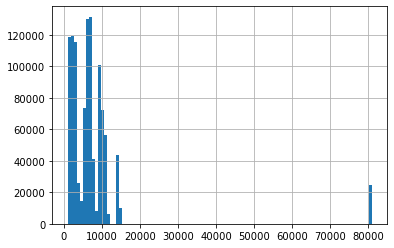

In [12]:
df["label"].hist(bins = 100)

<AxesSubplot:>

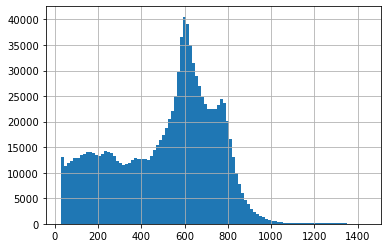

In [13]:
df["time_to_under"].hist(bins = 100)

Найдем наиболее популярную станцию

In [14]:
df["label"].value_counts()

3002     17272
6008     15541
1022     13758
5010     13122
7022     13080
         ...  
13002       24
13003       23
13006       17
13005       14
13004        7
Name: label, Length: 276, dtype: int64

In [15]:
df[df["label"] == int(df["label"].value_counts().index[0])].head()

,ticket_type_nm,entrance_id,station_id,line_id,pass_dttm,time_to_under,label
id,,,,,,,
61,Социальная карта жителя Моск. области,218,8003,8,2022-09-12 05:22:19,677.233333,3002
234,90 дней ЕДИНЫЙ ТК,221,8005,8,2022-09-12 05:28:54,706.883333,3002
308,30 дней ЕДИНЫЙ ТК,2227,10018,10,2022-09-12 05:29:53,792.900000,3002
421,30 дней ЕДИНЫЙ ТК,730,10007,10,2022-09-12 05:30:24,290.266667,3002
527,КОШЕЛЕК,343,7018,7,2022-09-12 05:30:53,829.166667,3002


In [16]:
df[df["station_id"] == int(df["label"].value_counts().index[0])].head()

,ticket_type_nm,entrance_id,station_id,line_id,pass_dttm,time_to_under,label
id,,,,,,,
718,30 дней ЕДИНЫЙ ТК,139,3002,3,2022-09-12 05:32:40,847.133333,3001
819,30 дней,139,3002,3,2022-09-12 05:33:59,905.666667,9009
1091,30 дней,139,3002,3,2022-09-12 05:37:17,873.616667,9005
1729,90 дней ЕДИНЫЙ ТК,139,3002,3,2022-09-12 05:43:19,608.583333,9024
1741,30 дней,139,3002,3,2022-09-12 05:43:26,867.733333,5009


Сделаем категорию **"ticket_type_nm"** числовой

In [17]:
df["ticket_type_nm"].value_counts()

КОШЕЛЕК                                                   262499
30 дней ЕДИНЫЙ ТК                                         177041
Социальная карта москвича                                 127022
30 дней                                                   117064
90 дней ЕДИНЫЙ ТК                                          58071
30 дней СК студента                                        48658
60 поездок ЕДИНЫЙ ТК                                       46542
30 дней Пригород ТК                                        45381
СК студента 30 дней                                        39395
ББК                                                        29674
30 дней СК учащегося                                       24307
365 дней ЕДИНЫЙ ТК                                         20859
СК учащегося 30 дней                                       16933
Социальная карта жителя Моск. области                      15551
90 дней                                                    12817
Пропуск FacePay          

In [18]:
### Произведем mean-target-encoding колонки Тип Билета
keys = dict(df.groupby(['ticket_type_nm'])['time_to_under'].mean())
df['ticket_type_nm'] = df['ticket_type_nm'].map(keys)

In [19]:
df['pass_dttm'] = pd.to_datetime(df['pass_dttm'], format="%Y-%m-%d %H:%M:%S")

In [20]:
df['dayofweek']=df['pass_dttm'].dt.dayofweek

In [21]:
df['day']=df['pass_dttm'].dt.day

In [22]:
df['hour']=df['pass_dttm'].dt.hour

In [23]:
df.drop('pass_dttm', axis =1, inplace = True)

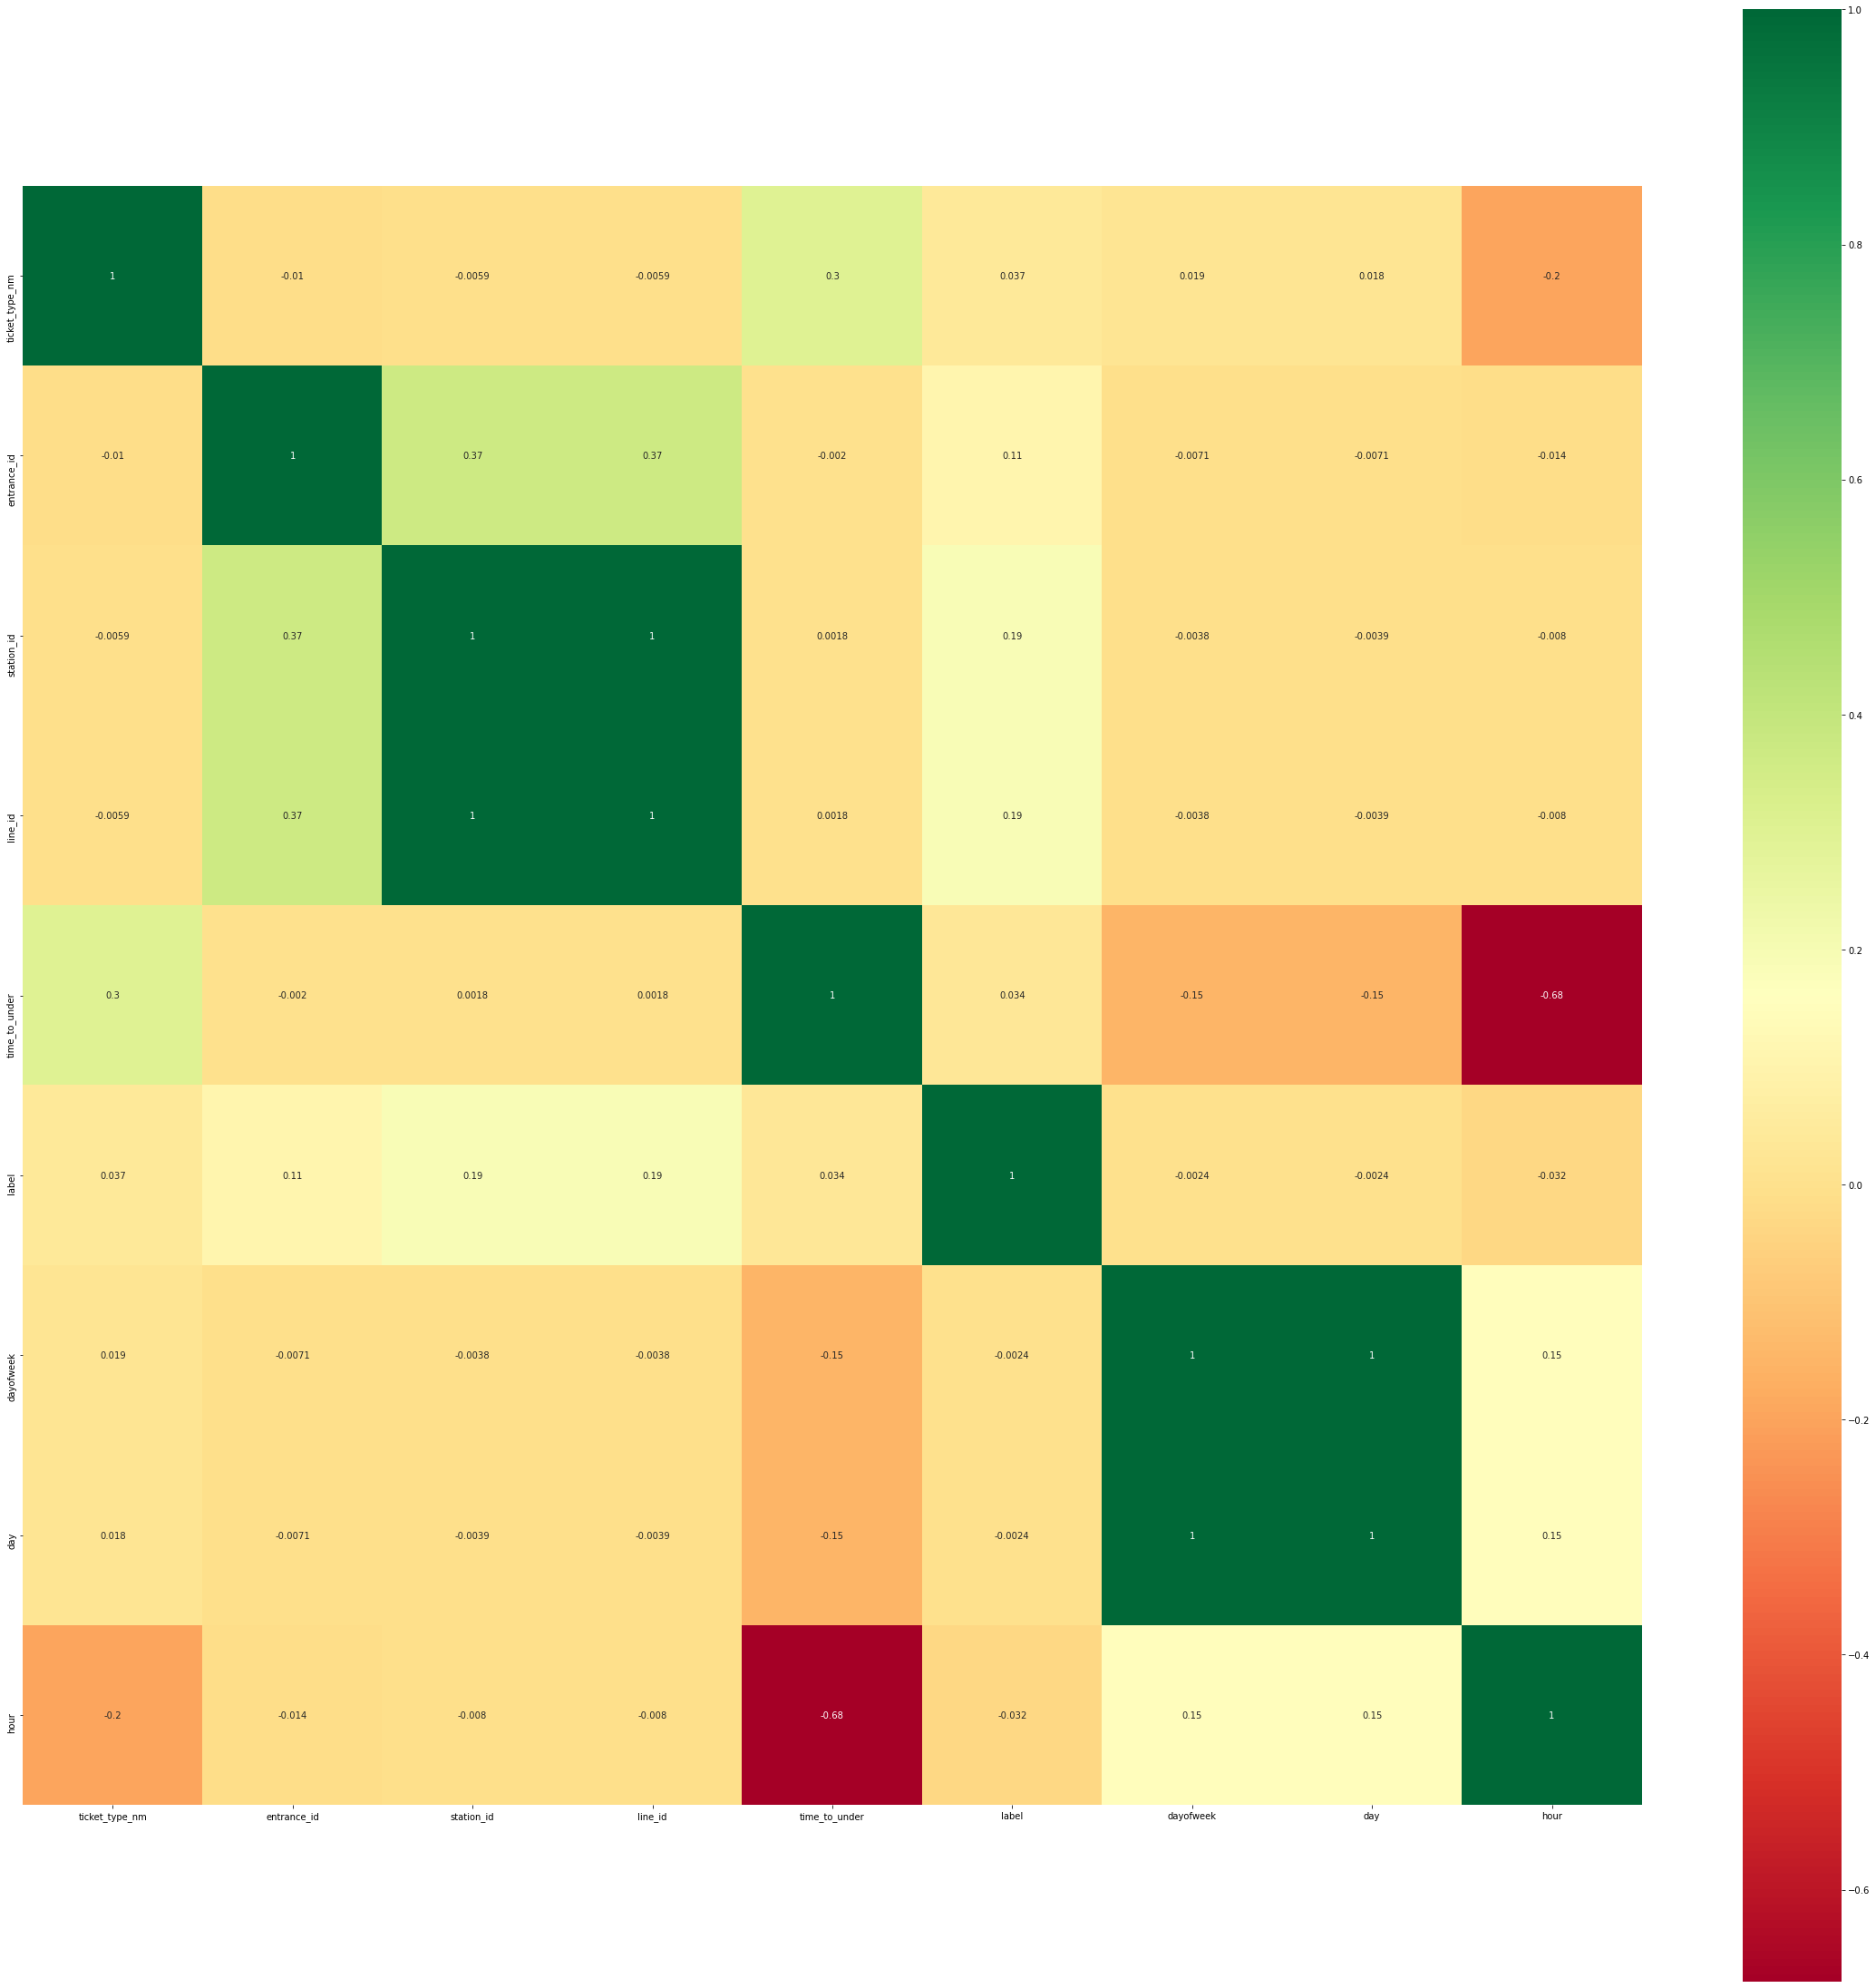

In [24]:
plt.rcParams['figure.figsize']=(40,40)

corr = df.corr()
g = sns.heatmap(corr, square = True, annot=True, cmap='RdYlGn')

Удалить линию или станцию?

In [25]:
df.drop('line_id', axis =1, inplace = True)

## Выделим выборки

In [26]:
X = df.drop(["time_to_under", "label"], axis = 1)
y = df[["time_to_under", "label"]]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
y_train['label'].value_counts()

3002     12066
6008     10898
1022      9607
7022      9166
5010      9034
         ...  
13002       17
13003       16
13006       14
13005       11
13004        6
Name: label, Length: 276, dtype: int64

## Обучение модели

Для станции 

In [47]:
from sklearn.model_selection import GridSearchCV


clf = RandomForestClassifier(random_state=42)

clf.fit(X_train, y_train['label'])

RandomForestClassifier(random_state=42)

In [32]:
### Новый вариант с linearsvc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
clf1 = OneVsRestClassifier(LinearSVC(random_state=42, dual=False))
clf1.fit(X_train, y_train['label'])

KeyboardInterrupt: 

In [33]:
### Новый вариант с linearsvc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
clf1 = LinearSVC(random_state=42, dual=False)
clf1.fit(X_train, y_train['label'])

LinearSVC(dual=False, random_state=42)

In [ ]:
### Новый вариант с svc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
сlf2 = OneVsRestClassifier(SVC(random_state=42))
сlf2.fit(X_train, y_train['label'])

Для времени

In [35]:
reg = RandomForestRegressor(random_state=42)

In [36]:
reg.fit(X_train, y_train["time_to_under"])

RandomForestRegressor(random_state=42)

## Оценка точности

In [ ]:
pred_class = clf1.predict(X_test)
pred_reg = reg.predict(X_test)

In [ ]:
from sklearn.metrics import recall_score, r2_score


score = 0.5 * recall_score(y_test["label"], pred_class , average='macro') +  0.5 * r2_score(y_test["time_to_under"], pred_reg)
score

## Обработка тестового датасета

In [41]:
tst = pd.read_csv("test_dataset_test.csv", index_col = 'id')

In [42]:
tst.drop('ticket_id', axis =1, inplace = True)

In [43]:
tst.drop('entrance_nm', axis =1, inplace = True)

In [44]:
tst.drop('station_nm', axis =1, inplace = True)

In [45]:
tst.drop('line_nm', axis =1, inplace = True)

In [46]:
### Произведем mean-target-encoding колонки Тип Билета
tst['ticket_type_nm'].replace(keys, inplace=True)
mean = tst[tst['ticket_type_nm']!='СК студента на 3 месяца']['ticket_type_nm'].mean()
tst['ticket_type_nm'].replace('СК студента на 3 месяца', mean, inplace = True)

In [47]:
tst['pass_dttm'] = pd.to_datetime(tst['pass_dttm'], format="%Y-%m-%d %H:%M:%S")

In [48]:
tst['dayofweek']=tst['pass_dttm'].dt.dayofweek

In [49]:
tst['day']=tst['pass_dttm'].dt.day

In [50]:
tst['hour']=tst['pass_dttm'].dt.hour

In [51]:
tst.drop('pass_dttm', axis =1, inplace = True)

In [52]:
tst.drop('line_id', axis =1, inplace = True)

### Предсказание финальное

In [54]:
pred_fin_class = clf1.predict(tst)

In [55]:
pred_fin_reg = reg.predict(tst)

In [56]:
tst['time_to_under']=pred_fin_reg
tst['label']=pred_fin_class
tst.drop(['ticket_type_nm','entrance_id','station_id','dayofweek','day','hour'], axis=1, inplace=True)

In [57]:
tst.head()

,time_to_under,label
id,,
1091022,820.497893,3002
1091023,287.292414,1022
1091024,541.747225,1022
1091025,693.883508,3002
1091026,820.497893,3002


In [58]:
tst.to_csv('solution2.csv')